## Learnings from Time Series, a Kaggle Course
Time Series Forecasting - applying machine learning algorithms to time series to produce predictions for the future.  
A time series is some set of recorded observations over a period of time, usually in some regular frequency.  
The time series used in this notebook is book sales in April 2000, recorded daily.

In [5]:
import pandas as pd

df = pd.read_csv("./time_series_demo/book_sales.csv", index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)

In [6]:
df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


In [7]:
import numpy as np

Two types of features unique to time series are time-step and lag.  
Time-step features can be drevied from the time index.  
The time dummy is a basic time-step feature that counts time steps in the series from start to finish.

In [8]:
# Time step dummy uses arange and length of the index
df['Time'] = np.arange(len(df.index))

In [9]:
df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

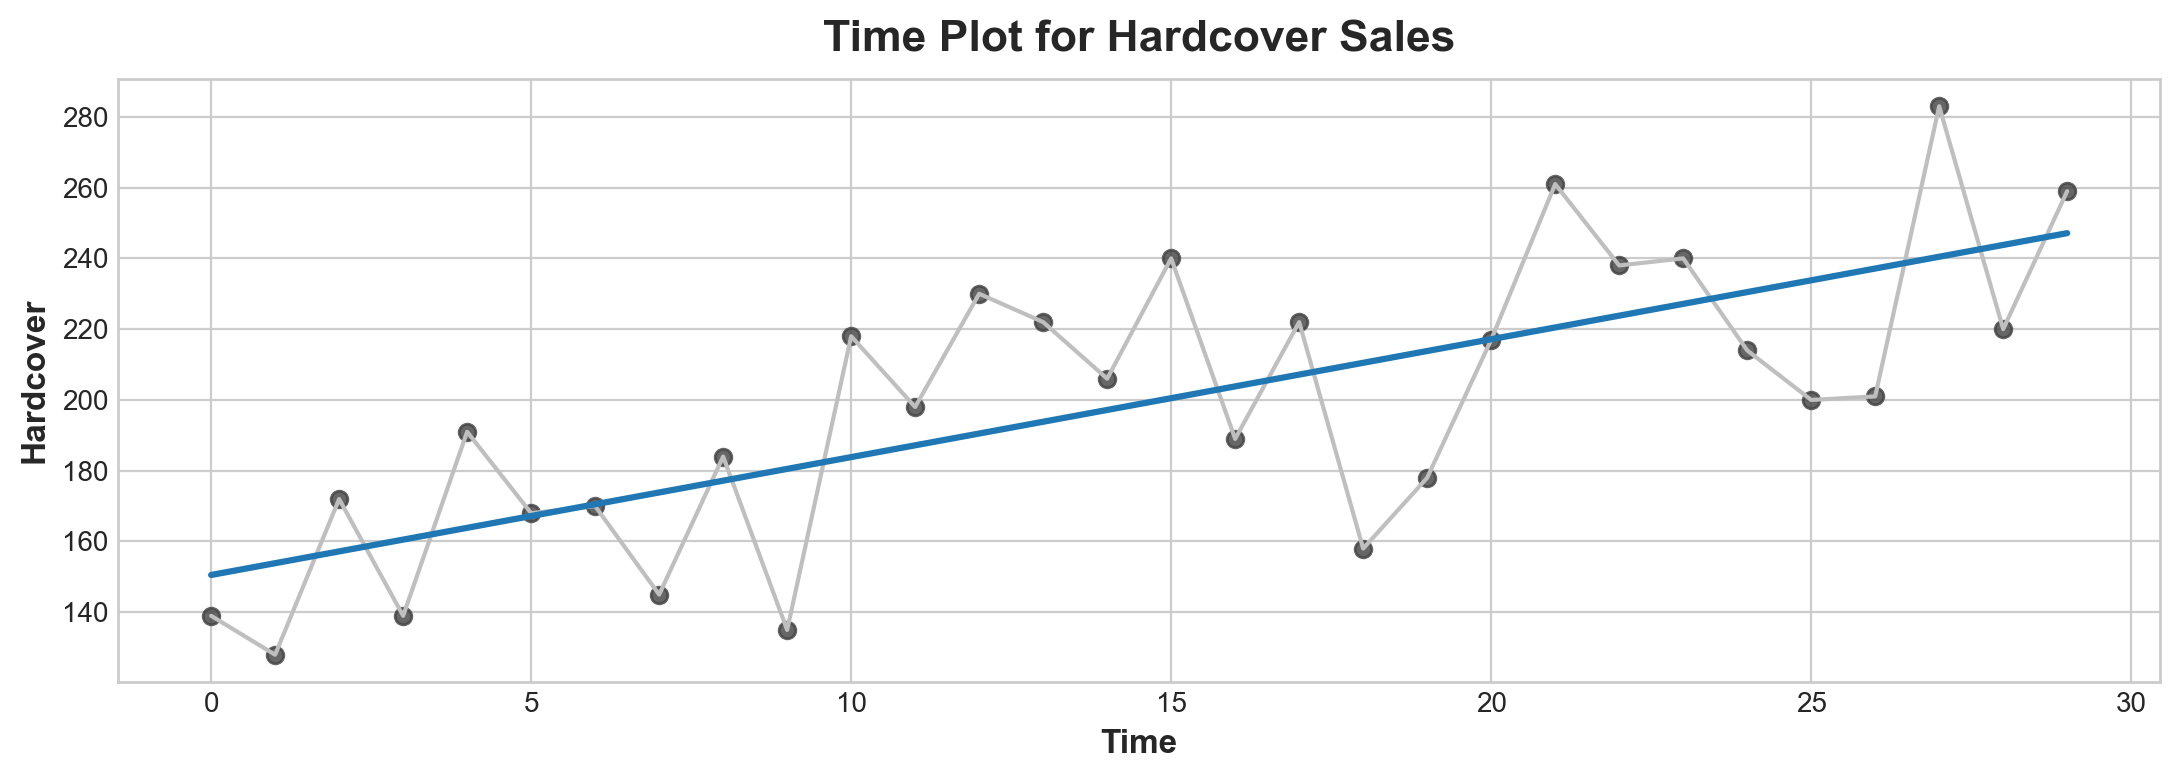

In [12]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot for Hardcover Sales');

Linear regression algorithms can be used to train forecasting models.  
Linear regression algo for 2 feature time-series:  target = weight_1 * feature_1 + weight_2 * feature_2 + bias  
The algo learns weigth_1, weight_2 and bias values during training to best fit the target (ordinary least squares)  
This algo is minimizing the squared error between the target and predictions.  
Weights can be called regression coefficients and bias called the intercept (where function crosses y-axis)

The lag feature is created by shifting values for recorded observations to appear later in time.  
Can be multiple steps, but in this example it is 1-step lag.

In [13]:
df['Lag_1'] = df['Hardcover'].shift(1)
df2 = df.reindex(columns=['Hardcover', 'Lag_1'])

In [14]:
df2.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Lag features allow plotting each obs in a series against a previous obs to fit a curve against it.  
Linear regression algo becomes: target = weight * lag + bias

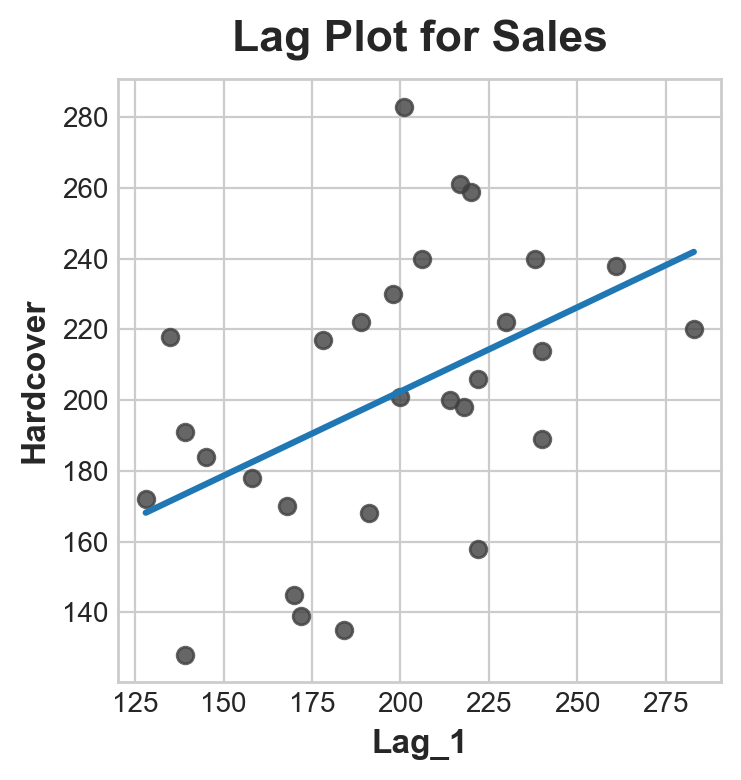

In [15]:
fig, ax = plt.subplots()
ax = sns.regplot(
    x='Lag_1',
    y='Hardcover',
    data=df2,
    ci=None,
    scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot for Sales');

Sales from one day to the previous day are correlated, as shown by this lag plot.  
When this type of relationship exists, lag feature will be useful.  
Lag features model serial dependence - when an observation can be predicted from previous observations.

For time series, training machine learning algos to make predictions mainly involves feature engineering with the time index and lags.  
These features are useful for more algos than just linear regerssion too.  

### Example: Tunnel traffic Nov 03-05

In [16]:
from pathlib import Path
from warnings import simplefilter

In [17]:
# ignore warnings about cleaning output cell data
simplefilter("ignore")

# set plot style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# load in traffic data
my_dir = Path("./time_series_demo")
tunnel = pd.read_csv(my_dir / "tunnel.csv", parse_dates=['Day'])

# create a time series by setting index to the date column Day
tunnel = tunnel.set_index("Day")

# by default, pandas creates time series as a sequence of measurements record at single moments (date time index).
# a period index represents a time series as a sequence of quantities accumulated over periods of time. 
# periods are easier to work with, so being used in the kaggle time series course
tunnel = tunnel.to_period()

In [18]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


Now create the time-step feature, in this case a time dummy

Important: don't have missing dates when creating time dummies by counting length of the series

In [19]:
df3 = tunnel.copy()
df3['Time'] = np.arange(len(tunnel.index))
df3.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


Now train a linear regression model (fit it to the data)

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# training data
X = df3.loc[:, ['Time']] # features
Y = df3.loc[:, 'NumVehicles'] # target

In [23]:
# train the model
model = LinearRegression()
model.fit(X, Y)

LinearRegression()

In [24]:
# store the fitted values as a time series with same time index as training data
y_pred = pd.Series(model.predict(X), index=X.index)

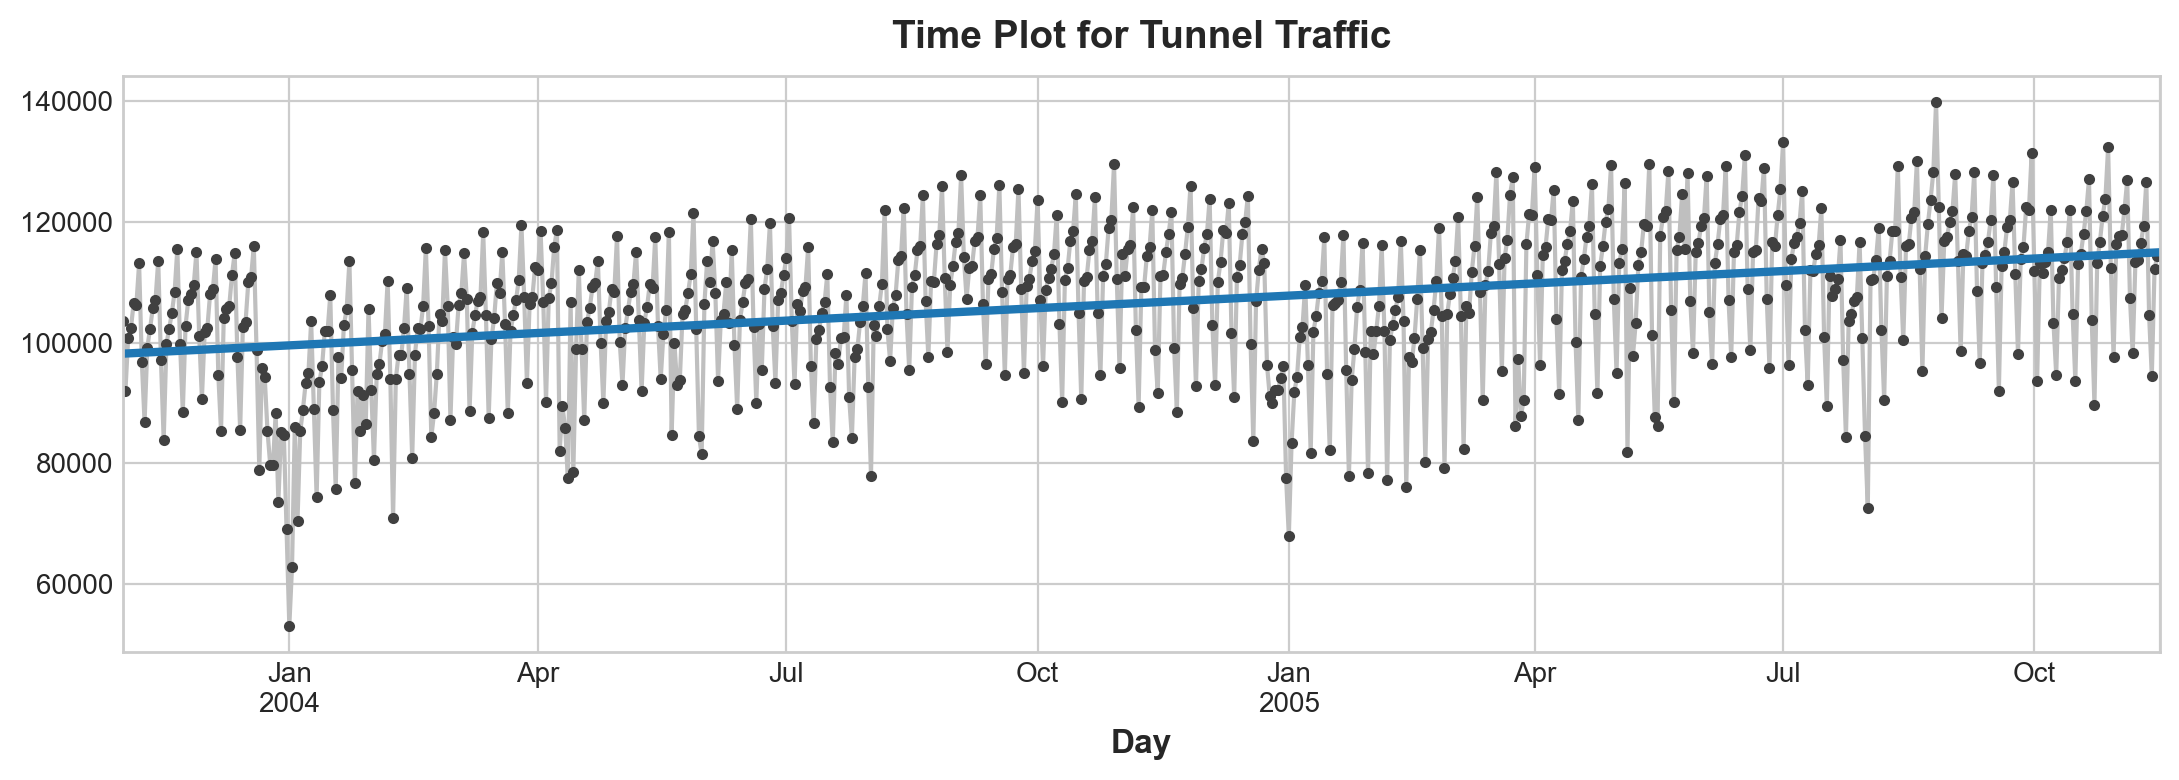

In [26]:
# plot the fitted data in a time series to see how time dummy creates the trend line
# NumVehinces = 22.5 * Time + 98176
ax = Y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot for Tunnel Traffic');

Pandas has a method to create a lag feature by lagging a series - the shift method.

In [28]:
df3['Lag_1'] = df3['NumVehicles'].shift(1)
df3.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


Need to handle missing values produced by a lag feature.  
One option is to fill them in - 0.0 or with first known value by backfilling.  
Can also jsut drop the missing values, and drop values in target from correspondind dates.

In [29]:
X = df3.loc[:, ['Lag_1']]
X.dropna(inplace=True)
Y = df3.loc[:, 'NumVehicles']
Y, X = Y.align(X, join='inner')

model = LinearRegression()
model.fit(X, Y)

y_pred = pd.Series(model.predict(X), index=X.index)

Lag plot shows how well model is able to fit the relationship between the number of vehicles one day and the previous day.

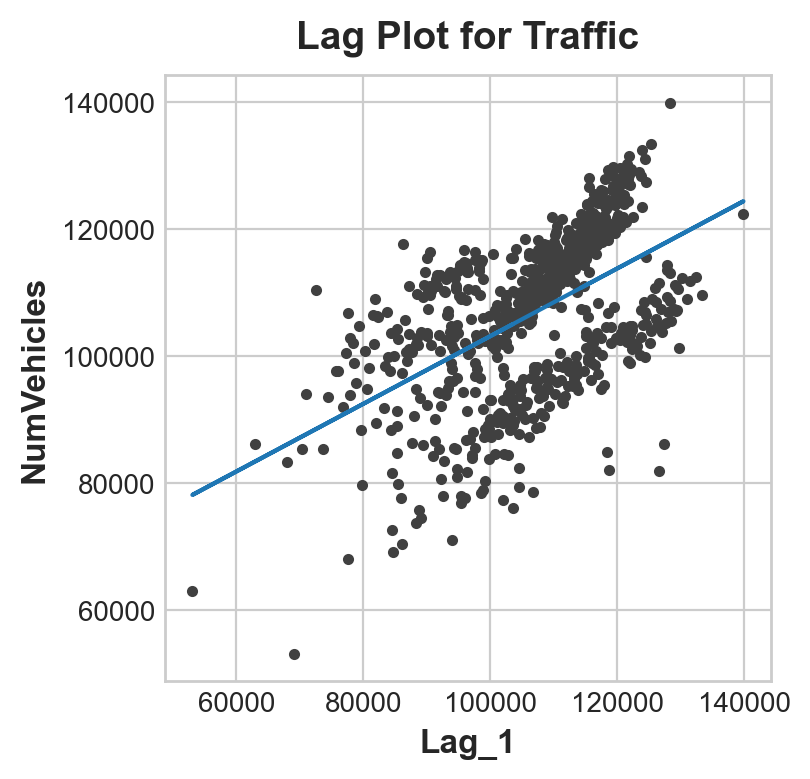

In [30]:
fix, ax = plt.subplots()
ax.plot(X['Lag_1'], Y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot for Traffic');

But what does this actually mean for how well we the model can predict the series across time?

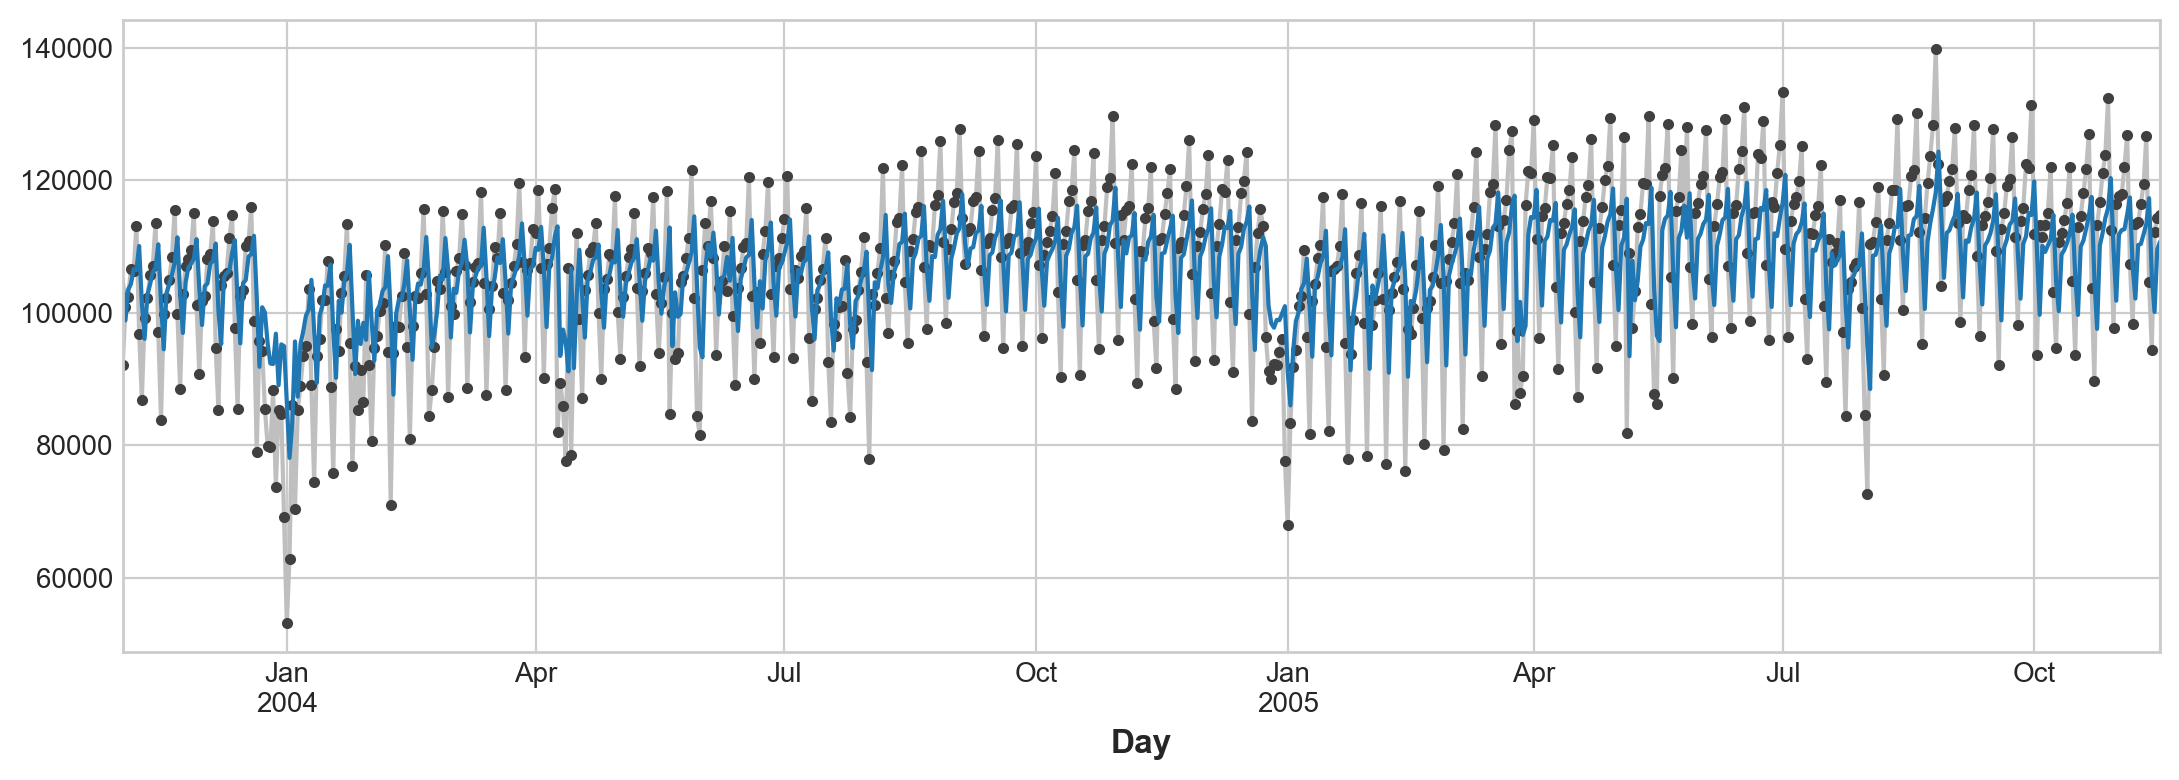

In [31]:
ax = Y.plot(**plot_params)
ax = y_pred.plot()

This time plot shows that forecasts now repsond to the beahvior of the series in the recent past.

The best time series models usually include some combination of time-step features and lag features.  